# 1. Dependencies

In [1]:
import numpy as np
import pandas as pd
from pandas import Grouper
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import *
import keras.metrics as metrics
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# 2. Data Preprocessing and Pipeline

In [0]:
train_df = pd.read_excel('./Train_dataset.xlsx', sheet_name='Diuresis_TS', )

In [3]:
train_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10714 entries, 0 to 10713
Data columns (total 8 columns):
people_ID              10714 non-null int64
2020-03-20 00:00:00    10714 non-null int64
2020-03-21 00:00:00    10714 non-null float64
2020-03-22 00:00:00    10714 non-null float64
2020-03-23 00:00:00    10714 non-null float64
2020-03-24 00:00:00    10714 non-null float64
2020-03-25 00:00:00    10714 non-null float64
2020-03-26 00:00:00    10714 non-null float64
dtypes: float64(6), int64(2)
memory usage: 669.8 KB


In [0]:
people_ID = train_df.people_ID

train_copy = train_df.drop(columns=['people_ID'], axis=1)

In [0]:
cols = train_copy.columns

In [6]:
train_copy.describe()

,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00
count,10714.000000,10714.000000,10714.000000,10714.000000,10714.000000,10714.000000,10714.000000
mean,278.877357,349.147508,434.360993,537.435133,660.177788,805.213345,981.255343
std,97.945646,117.553040,141.053939,169.284924,203.155177,243.786212,292.538346
min,110.000000,145.000000,188.200000,240.440000,304.228000,378.073600,468.461120
25%,194.000000,247.800000,312.760000,391.384000,484.918600,594.902320,729.203328
50%,276.000000,346.200000,430.840000,533.064000,654.822400,798.786880,973.388672
75%,364.000000,451.000000,557.260000,685.136000,837.211600,1017.653920,1236.308736
max,450.000000,556.000000,683.800000,838.360000,1020.904000,1238.084800,1501.798080


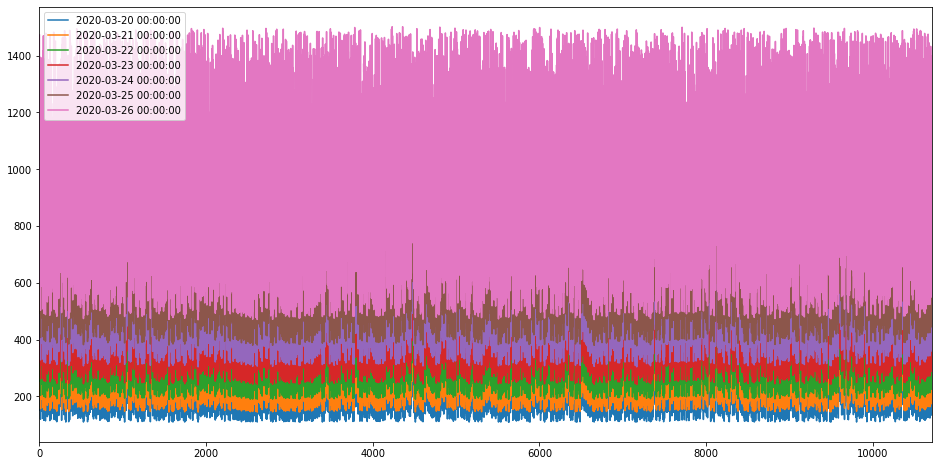

In [7]:
# infections vs date
# y-axis - number of infections
# x-axis - people_ID
train_copy.plot(figsize=(16, 8));

In [0]:
## infection rate is high on 26th March 

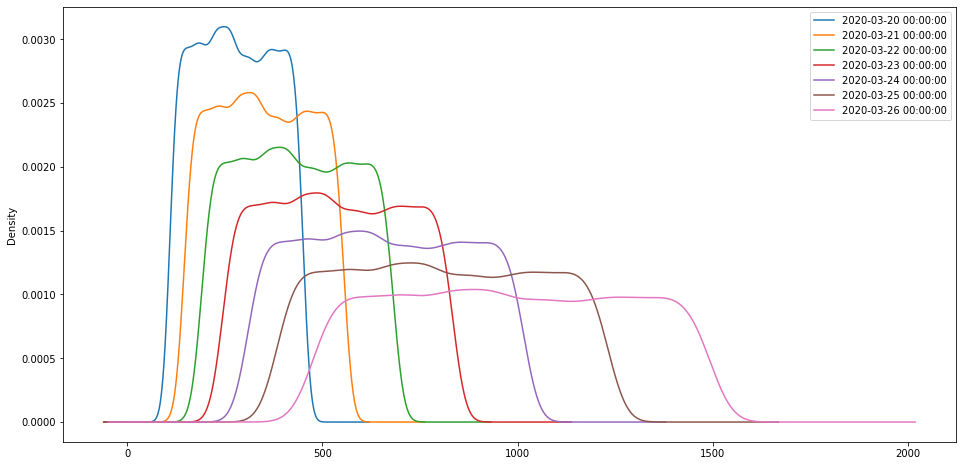

In [9]:
# density plot
train_copy.plot(kind="kde", figsize=(16, 8));

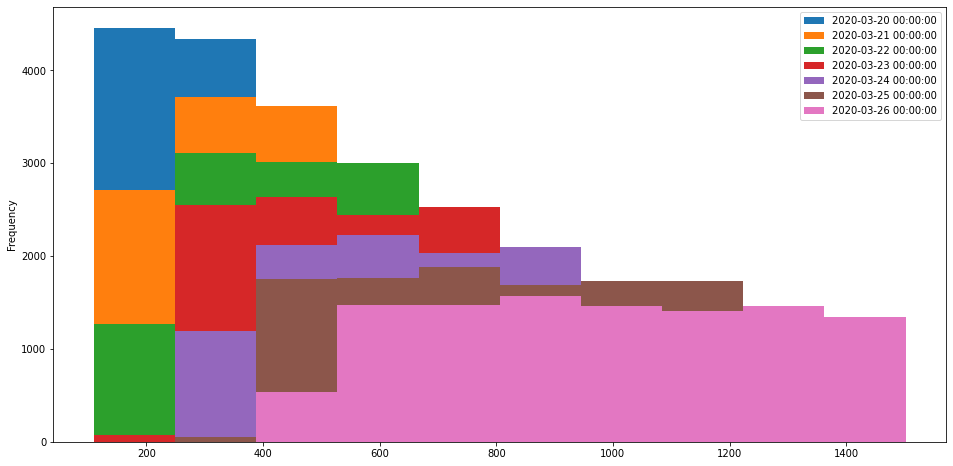

In [10]:
train_copy.plot(kind="hist", figsize=(16, 8));

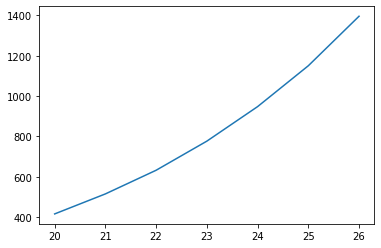

In [11]:
# #infections vs date for a single people_ID
plt.plot([col.date().day for col in cols], train_copy.values[np.random.randint(0, train_copy.values.shape[1])]);

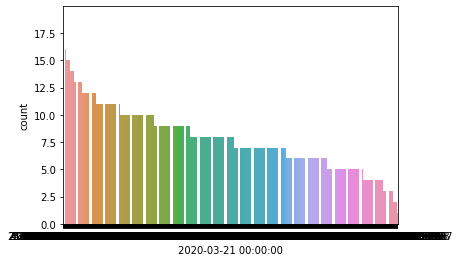

In [12]:
sns.countplot(x = cols[1],
              data = train_copy,
              order = train_copy[cols[1]].value_counts().index);

In [13]:
train_df.head()

,people_ID,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00
0,1,441,544.2,669.64,821.368,1002.2416,1215.68992,1472.627904
1,2,151,197.2,253.24,321.688,399.9256,492.91072,606.892864
2,3,416,515.2,632.44,776.728,947.7736,1150.32832,1395.793984
3,4,410,506.0,621.40,761.880,928.1560,1126.78720,1368.344640
4,5,390,483.0,595.00,730.200,892.8400,1084.40800,1315.889600


In [0]:
train_transpose = train_copy.transpose()

In [15]:
train_transpose.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10674,10675,10676,10677,10678,10679,10680,10681,10682,10683,10684,10685,10686,10687,10688,10689,10690,10691,10692,10693,10694,10695,10696,10697,10698,10699,10700,10701,10702,10703,10704,10705,10706,10707,10708,10709,10710,10711,10712,10713
2020-03-20 00:00:00,441.0000,151.0000,416.0000,410.000,390.00,389.0000,322.0000,194.0000,310.000,242.0000,373.0000,192.0000,403.0000,120.000,382.0000,239.0000,199.0000,182.0000,181.0000,220.000,246.0000,220.000,415.000,203.0000,148.0000,381.0000,251.0000,185.000,365.000,405.000,240.000,236.0000,315.000,253.0000,289.0000,281.0000,200.00,365.000,189.0000,177.0000,...,436.0000,301.0000,149.0000,426.0000,268.0000,165.000,176.0000,178.0000,250.000,189.0000,411.0000,124.0000,302.0000,426.0000,395.00,388.0000,149.0000,418.0000,234.0000,159.0000,431.0000,248.0000,145.000,218.0000,372.0000,347.0000,379.0000,256.0000,417.0000,389.0000,339.0000,241.0000,183.0000,297.0000,397.0000,134.0000,387.0000,177.0000,352.0000,181.0000
2020-03-21 00:00:00,544.2000,197.2000,515.2000,506.000,483.00,480.8000,401.4000,246.8000,385.000,303.4000,463.6000,245.4000,497.6000,157.000,474.4000,301.8000,253.8000,232.4000,233.2000,279.000,308.2000,278.000,514.000,258.6000,190.6000,473.2000,315.2000,236.000,454.000,501.000,304.000,297.2000,393.000,317.6000,360.8000,351.2000,253.00,453.000,239.8000,225.4000,...,536.2000,376.2000,194.8000,526.2000,334.6000,214.000,224.2000,226.6000,314.000,240.8000,508.2000,163.8000,376.4000,526.2000,487.00,481.6000,192.8000,515.6000,295.8000,203.8000,532.2000,312.6000,187.000,274.6000,461.4000,430.4000,467.8000,320.2000,515.4000,479.8000,420.8000,305.2000,232.6000,370.4000,489.4000,173.8000,479.4000,228.4000,438.4000,230.2000
2020-03-22 00:00:00,669.6400,253.2400,632.4400,621.400,595.00,591.1600,497.0800,310.3600,477.400,379.4800,570.5200,309.8800,612.5200,203.800,583.4800,377.5600,318.7600,295.4800,295.2400,351.400,385.2400,350.200,632.200,324.5200,242.9200,584.4400,392.4400,299.800,560.200,616.600,380.200,372.0400,485.800,397.7200,448.3600,436.8400,319.00,557.800,303.1600,285.8800,...,658.8400,468.0400,250.3600,648.0400,418.1200,272.200,284.4400,286.1200,393.400,304.3600,626.4400,213.1600,467.0800,646.8400,601.00,594.5200,245.5600,634.1200,369.1600,261.1600,652.8400,391.7200,238.600,344.9200,570.2800,530.6800,576.7600,399.6400,632.6800,589.9600,519.1600,382.8400,293.3200,459.8800,603.8800,225.1600,591.8800,288.2800,542.6800,290.4400
2020-03-23 00:00:00,821.3680,321.6880,776.7280,761.880,730.20,723.9920,611.0960,388.6320,589.080,469.9760,702.4240,389.6560,751.2240,262.360,717.9760,470.8720,398.7120,372.3760,372.0880,439.480,480.0880,436.440,776.440,404.0240,309.3040,719.1280,485.5280,377.560,688.440,754.520,474.040,464.2480,600.760,491.8640,555.8320,542.0080,400.60,685.560,378.3920,360.8560,...,805.2080,577.8480,318.2320,793.8480,519.5440,342.840,355.9280,361.1440,489.880,381.4320,769.5280,271.9920,576.6960,792.4080,735.80,728.0240,312.4720,775.5440,460.7920,329.5920,798.0080,487.8640,304.120,428.5040,698.9360,651.4160,708.3120,497.3680,777.0160,722.5520,639.1920,477.2080,368.1840,568.0560,742.4560,287.9920,724.8560,362.1360,665.8160,366.3280
2020-03-24 00:00:00,1002.2416,399.9256,947.7736,928.156,892.84,882.6904,749.0152,482.9584,720.796,578.7712,857.7088,482.3872,917.1688,328.732,876.3712,580.7464,494.1544,461.6512,463.1056,542.176,590.9056,539.428,945.628,500.5288,386.8648,877.7536,596.5336,468.772,841.828,921.124,582.748,573.6976,736.612,605.0368,680.8984,665.2096,496.42,838.372,469.7704,448.7272,...,981.9496,710.0176,398.4784,968.3176,639.1528,426.208,441.9136,447.2728,603.556,473.4184,940.0336,342.9904,707.7352,966.5896,896.86,889.3288,390.6664,944.5528,568.6504,411.2104,973.3096,602.0368,379.744,529.9048,853.5232,795.5992,863.8744,612.5416,949.0192,881.8624,780.9304,588.3496,458.4208,698.2672,906.6472,359.4904,884.6272,448.4632,814.6792,455.2936


In [16]:
train_transpose[0]

2020-03-20     441.000000
2020-03-21     544.200000
2020-03-22     669.640000
2020-03-23     821.368000
2020-03-24    1002.241600
2020-03-25    1215.689920
2020-03-26    1472.627904
Name: 0, dtype: float64

In [0]:
cols_date = [datetime for col in cols]

In [0]:
date_df = pd.DataFrame(cols_date, columns=['date'])

In [0]:
train_transpose = train_copy.transpose()

In [18]:
train_transpose.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10674,10675,10676,10677,10678,10679,10680,10681,10682,10683,10684,10685,10686,10687,10688,10689,10690,10691,10692,10693,10694,10695,10696,10697,10698,10699,10700,10701,10702,10703,10704,10705,10706,10707,10708,10709,10710,10711,10712,10713
2020-03-20 00:00:00,441.0000,151.0000,416.0000,410.000,390.00,389.0000,322.0000,194.0000,310.000,242.0000,373.0000,192.0000,403.0000,120.000,382.0000,239.0000,199.0000,182.0000,181.0000,220.000,246.0000,220.000,415.000,203.0000,148.0000,381.0000,251.0000,185.000,365.000,405.000,240.000,236.0000,315.000,253.0000,289.0000,281.0000,200.00,365.000,189.0000,177.0000,...,436.0000,301.0000,149.0000,426.0000,268.0000,165.000,176.0000,178.0000,250.000,189.0000,411.0000,124.0000,302.0000,426.0000,395.00,388.0000,149.0000,418.0000,234.0000,159.0000,431.0000,248.0000,145.000,218.0000,372.0000,347.0000,379.0000,256.0000,417.0000,389.0000,339.0000,241.0000,183.0000,297.0000,397.0000,134.0000,387.0000,177.0000,352.0000,181.0000
2020-03-21 00:00:00,544.2000,197.2000,515.2000,506.000,483.00,480.8000,401.4000,246.8000,385.000,303.4000,463.6000,245.4000,497.6000,157.000,474.4000,301.8000,253.8000,232.4000,233.2000,279.000,308.2000,278.000,514.000,258.6000,190.6000,473.2000,315.2000,236.000,454.000,501.000,304.000,297.2000,393.000,317.6000,360.8000,351.2000,253.00,453.000,239.8000,225.4000,...,536.2000,376.2000,194.8000,526.2000,334.6000,214.000,224.2000,226.6000,314.000,240.8000,508.2000,163.8000,376.4000,526.2000,487.00,481.6000,192.8000,515.6000,295.8000,203.8000,532.2000,312.6000,187.000,274.6000,461.4000,430.4000,467.8000,320.2000,515.4000,479.8000,420.8000,305.2000,232.6000,370.4000,489.4000,173.8000,479.4000,228.4000,438.4000,230.2000
2020-03-22 00:00:00,669.6400,253.2400,632.4400,621.400,595.00,591.1600,497.0800,310.3600,477.400,379.4800,570.5200,309.8800,612.5200,203.800,583.4800,377.5600,318.7600,295.4800,295.2400,351.400,385.2400,350.200,632.200,324.5200,242.9200,584.4400,392.4400,299.800,560.200,616.600,380.200,372.0400,485.800,397.7200,448.3600,436.8400,319.00,557.800,303.1600,285.8800,...,658.8400,468.0400,250.3600,648.0400,418.1200,272.200,284.4400,286.1200,393.400,304.3600,626.4400,213.1600,467.0800,646.8400,601.00,594.5200,245.5600,634.1200,369.1600,261.1600,652.8400,391.7200,238.600,344.9200,570.2800,530.6800,576.7600,399.6400,632.6800,589.9600,519.1600,382.8400,293.3200,459.8800,603.8800,225.1600,591.8800,288.2800,542.6800,290.4400
2020-03-23 00:00:00,821.3680,321.6880,776.7280,761.880,730.20,723.9920,611.0960,388.6320,589.080,469.9760,702.4240,389.6560,751.2240,262.360,717.9760,470.8720,398.7120,372.3760,372.0880,439.480,480.0880,436.440,776.440,404.0240,309.3040,719.1280,485.5280,377.560,688.440,754.520,474.040,464.2480,600.760,491.8640,555.8320,542.0080,400.60,685.560,378.3920,360.8560,...,805.2080,577.8480,318.2320,793.8480,519.5440,342.840,355.9280,361.1440,489.880,381.4320,769.5280,271.9920,576.6960,792.4080,735.80,728.0240,312.4720,775.5440,460.7920,329.5920,798.0080,487.8640,304.120,428.5040,698.9360,651.4160,708.3120,497.3680,777.0160,722.5520,639.1920,477.2080,368.1840,568.0560,742.4560,287.9920,724.8560,362.1360,665.8160,366.3280
2020-03-24 00:00:00,1002.2416,399.9256,947.7736,928.156,892.84,882.6904,749.0152,482.9584,720.796,578.7712,857.7088,482.3872,917.1688,328.732,876.3712,580.7464,494.1544,461.6512,463.1056,542.176,590.9056,539.428,945.628,500.5288,386.8648,877.7536,596.5336,468.772,841.828,921.124,582.748,573.6976,736.612,605.0368,680.8984,665.2096,496.42,838.372,469.7704,448.7272,...,981.9496,710.0176,398.4784,968.3176,639.1528,426.208,441.9136,447.2728,603.556,473.4184,940.0336,342.9904,707.7352,966.5896,896.86,889.3288,390.6664,944.5528,568.6504,411.2104,973.3096,602.0368,379.744,529.9048,853.5232,795.5992,863.8744,612.5416,949.0192,881.8624,780.9304,588.3496,458.4208,698.2672,906.6472,359.4904,884.6272,448.4632,814.6792,455.2936


In [0]:
# train_transpose

In [0]:
# set the index as date 
train_transpose['date'] = train_transpose.index

In [21]:
train_transpose.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10675,10676,10677,10678,10679,10680,10681,10682,10683,10684,10685,10686,10687,10688,10689,10690,10691,10692,10693,10694,10695,10696,10697,10698,10699,10700,10701,10702,10703,10704,10705,10706,10707,10708,10709,10710,10711,10712,10713,date
2020-03-20 00:00:00,441.0000,151.0000,416.0000,410.000,390.00,389.0000,322.0000,194.0000,310.000,242.0000,373.0000,192.0000,403.0000,120.000,382.0000,239.0000,199.0000,182.0000,181.0000,220.000,246.0000,220.000,415.000,203.0000,148.0000,381.0000,251.0000,185.000,365.000,405.000,240.000,236.0000,315.000,253.0000,289.0000,281.0000,200.00,365.000,189.0000,177.0000,...,301.0000,149.0000,426.0000,268.0000,165.000,176.0000,178.0000,250.000,189.0000,411.0000,124.0000,302.0000,426.0000,395.00,388.0000,149.0000,418.0000,234.0000,159.0000,431.0000,248.0000,145.000,218.0000,372.0000,347.0000,379.0000,256.0000,417.0000,389.0000,339.0000,241.0000,183.0000,297.0000,397.0000,134.0000,387.0000,177.0000,352.0000,181.0000,2020-03-20
2020-03-21 00:00:00,544.2000,197.2000,515.2000,506.000,483.00,480.8000,401.4000,246.8000,385.000,303.4000,463.6000,245.4000,497.6000,157.000,474.4000,301.8000,253.8000,232.4000,233.2000,279.000,308.2000,278.000,514.000,258.6000,190.6000,473.2000,315.2000,236.000,454.000,501.000,304.000,297.2000,393.000,317.6000,360.8000,351.2000,253.00,453.000,239.8000,225.4000,...,376.2000,194.8000,526.2000,334.6000,214.000,224.2000,226.6000,314.000,240.8000,508.2000,163.8000,376.4000,526.2000,487.00,481.6000,192.8000,515.6000,295.8000,203.8000,532.2000,312.6000,187.000,274.6000,461.4000,430.4000,467.8000,320.2000,515.4000,479.8000,420.8000,305.2000,232.6000,370.4000,489.4000,173.8000,479.4000,228.4000,438.4000,230.2000,2020-03-21
2020-03-22 00:00:00,669.6400,253.2400,632.4400,621.400,595.00,591.1600,497.0800,310.3600,477.400,379.4800,570.5200,309.8800,612.5200,203.800,583.4800,377.5600,318.7600,295.4800,295.2400,351.400,385.2400,350.200,632.200,324.5200,242.9200,584.4400,392.4400,299.800,560.200,616.600,380.200,372.0400,485.800,397.7200,448.3600,436.8400,319.00,557.800,303.1600,285.8800,...,468.0400,250.3600,648.0400,418.1200,272.200,284.4400,286.1200,393.400,304.3600,626.4400,213.1600,467.0800,646.8400,601.00,594.5200,245.5600,634.1200,369.1600,261.1600,652.8400,391.7200,238.600,344.9200,570.2800,530.6800,576.7600,399.6400,632.6800,589.9600,519.1600,382.8400,293.3200,459.8800,603.8800,225.1600,591.8800,288.2800,542.6800,290.4400,2020-03-22
2020-03-23 00:00:00,821.3680,321.6880,776.7280,761.880,730.20,723.9920,611.0960,388.6320,589.080,469.9760,702.4240,389.6560,751.2240,262.360,717.9760,470.8720,398.7120,372.3760,372.0880,439.480,480.0880,436.440,776.440,404.0240,309.3040,719.1280,485.5280,377.560,688.440,754.520,474.040,464.2480,600.760,491.8640,555.8320,542.0080,400.60,685.560,378.3920,360.8560,...,577.8480,318.2320,793.8480,519.5440,342.840,355.9280,361.1440,489.880,381.4320,769.5280,271.9920,576.6960,792.4080,735.80,728.0240,312.4720,775.5440,460.7920,329.5920,798.0080,487.8640,304.120,428.5040,698.9360,651.4160,708.3120,497.3680,777.0160,722.5520,639.1920,477.2080,368.1840,568.0560,742.4560,287.9920,724.8560,362.1360,665.8160,366.3280,2020-03-23
2020-03-24 00:00:00,1002.2416,399.9256,947.7736,928.156,892.84,882.6904,749.0152,482.9584,720.796,578.7712,857.7088,482.3872,917.1688,328.732,876.3712,580.7464,494.1544,461.6512,463.1056,542.176,590.9056,539.428,945.628,500.5288,386.8648,877.7536,596.5336,468.772,841.828,921.124,582.748,573.6976,736.612,605.0368,680.8984,665.2096,496.42,838.372,469.7704,448.7272,...,710.0176,398.4784,968.3176,639.1528,426.208,441.9136,447.2728,603.556,473.4184,940.0336,342.9904,707.7352,966.5896,896.86,889.3288,390.6664,944.5528,568.6504,411.2104,973.3096,602.0368,379.744,529.9048,853.5232,795.5992,863.8744,612.5416,949.0192,881.8624,780.9304,588.3496,458.4208,698.2672,906.6472,359.4904,884.6272,448.4632,814.6792,455.2936,2020-03-24


In [0]:
# since we have date as index we no longer need index
train_transpose = train_transpose.reset_index(drop=True)

In [23]:
train_transpose.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10675,10676,10677,10678,10679,10680,10681,10682,10683,10684,10685,10686,10687,10688,10689,10690,10691,10692,10693,10694,10695,10696,10697,10698,10699,10700,10701,10702,10703,10704,10705,10706,10707,10708,10709,10710,10711,10712,10713,date
0,441.0000,151.0000,416.0000,410.000,390.00,389.0000,322.0000,194.0000,310.000,242.0000,373.0000,192.0000,403.0000,120.000,382.0000,239.0000,199.0000,182.0000,181.0000,220.000,246.0000,220.000,415.000,203.0000,148.0000,381.0000,251.0000,185.000,365.000,405.000,240.000,236.0000,315.000,253.0000,289.0000,281.0000,200.00,365.000,189.0000,177.0000,...,301.0000,149.0000,426.0000,268.0000,165.000,176.0000,178.0000,250.000,189.0000,411.0000,124.0000,302.0000,426.0000,395.00,388.0000,149.0000,418.0000,234.0000,159.0000,431.0000,248.0000,145.000,218.0000,372.0000,347.0000,379.0000,256.0000,417.0000,389.0000,339.0000,241.0000,183.0000,297.0000,397.0000,134.0000,387.0000,177.0000,352.0000,181.0000,2020-03-20
1,544.2000,197.2000,515.2000,506.000,483.00,480.8000,401.4000,246.8000,385.000,303.4000,463.6000,245.4000,497.6000,157.000,474.4000,301.8000,253.8000,232.4000,233.2000,279.000,308.2000,278.000,514.000,258.6000,190.6000,473.2000,315.2000,236.000,454.000,501.000,304.000,297.2000,393.000,317.6000,360.8000,351.2000,253.00,453.000,239.8000,225.4000,...,376.2000,194.8000,526.2000,334.6000,214.000,224.2000,226.6000,314.000,240.8000,508.2000,163.8000,376.4000,526.2000,487.00,481.6000,192.8000,515.6000,295.8000,203.8000,532.2000,312.6000,187.000,274.6000,461.4000,430.4000,467.8000,320.2000,515.4000,479.8000,420.8000,305.2000,232.6000,370.4000,489.4000,173.8000,479.4000,228.4000,438.4000,230.2000,2020-03-21
2,669.6400,253.2400,632.4400,621.400,595.00,591.1600,497.0800,310.3600,477.400,379.4800,570.5200,309.8800,612.5200,203.800,583.4800,377.5600,318.7600,295.4800,295.2400,351.400,385.2400,350.200,632.200,324.5200,242.9200,584.4400,392.4400,299.800,560.200,616.600,380.200,372.0400,485.800,397.7200,448.3600,436.8400,319.00,557.800,303.1600,285.8800,...,468.0400,250.3600,648.0400,418.1200,272.200,284.4400,286.1200,393.400,304.3600,626.4400,213.1600,467.0800,646.8400,601.00,594.5200,245.5600,634.1200,369.1600,261.1600,652.8400,391.7200,238.600,344.9200,570.2800,530.6800,576.7600,399.6400,632.6800,589.9600,519.1600,382.8400,293.3200,459.8800,603.8800,225.1600,591.8800,288.2800,542.6800,290.4400,2020-03-22
3,821.3680,321.6880,776.7280,761.880,730.20,723.9920,611.0960,388.6320,589.080,469.9760,702.4240,389.6560,751.2240,262.360,717.9760,470.8720,398.7120,372.3760,372.0880,439.480,480.0880,436.440,776.440,404.0240,309.3040,719.1280,485.5280,377.560,688.440,754.520,474.040,464.2480,600.760,491.8640,555.8320,542.0080,400.60,685.560,378.3920,360.8560,...,577.8480,318.2320,793.8480,519.5440,342.840,355.9280,361.1440,489.880,381.4320,769.5280,271.9920,576.6960,792.4080,735.80,728.0240,312.4720,775.5440,460.7920,329.5920,798.0080,487.8640,304.120,428.5040,698.9360,651.4160,708.3120,497.3680,777.0160,722.5520,639.1920,477.2080,368.1840,568.0560,742.4560,287.9920,724.8560,362.1360,665.8160,366.3280,2020-03-23
4,1002.2416,399.9256,947.7736,928.156,892.84,882.6904,749.0152,482.9584,720.796,578.7712,857.7088,482.3872,917.1688,328.732,876.3712,580.7464,494.1544,461.6512,463.1056,542.176,590.9056,539.428,945.628,500.5288,386.8648,877.7536,596.5336,468.772,841.828,921.124,582.748,573.6976,736.612,605.0368,680.8984,665.2096,496.42,838.372,469.7704,448.7272,...,710.0176,398.4784,968.3176,639.1528,426.208,441.9136,447.2728,603.556,473.4184,940.0336,342.9904,707.7352,966.5896,896.86,889.3288,390.6664,944.5528,568.6504,411.2104,973.3096,602.0368,379.744,529.9048,853.5232,795.5992,863.8744,612.5416,949.0192,881.8624,780.9304,588.3496,458.4208,698.2672,906.6472,359.4904,884.6272,448.4632,814.6792,455.2936,2020-03-24


In [0]:
train_transpose = train_transpose.set_index(train_transpose.date)

In [25]:
train_transpose.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10675,10676,10677,10678,10679,10680,10681,10682,10683,10684,10685,10686,10687,10688,10689,10690,10691,10692,10693,10694,10695,10696,10697,10698,10699,10700,10701,10702,10703,10704,10705,10706,10707,10708,10709,10710,10711,10712,10713,date
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-20,441.0000,151.0000,416.0000,410.000,390.00,389.0000,322.0000,194.0000,310.000,242.0000,373.0000,192.0000,403.0000,120.000,382.0000,239.0000,199.0000,182.0000,181.0000,220.000,246.0000,220.000,415.000,203.0000,148.0000,381.0000,251.0000,185.000,365.000,405.000,240.000,236.0000,315.000,253.0000,289.0000,281.0000,200.00,365.000,189.0000,177.0000,...,301.0000,149.0000,426.0000,268.0000,165.000,176.0000,178.0000,250.000,189.0000,411.0000,124.0000,302.0000,426.0000,395.00,388.0000,149.0000,418.0000,234.0000,159.0000,431.0000,248.0000,145.000,218.0000,372.0000,347.0000,379.0000,256.0000,417.0000,389.0000,339.0000,241.0000,183.0000,297.0000,397.0000,134.0000,387.0000,177.0000,352.0000,181.0000,2020-03-20
2020-03-21,544.2000,197.2000,515.2000,506.000,483.00,480.8000,401.4000,246.8000,385.000,303.4000,463.6000,245.4000,497.6000,157.000,474.4000,301.8000,253.8000,232.4000,233.2000,279.000,308.2000,278.000,514.000,258.6000,190.6000,473.2000,315.2000,236.000,454.000,501.000,304.000,297.2000,393.000,317.6000,360.8000,351.2000,253.00,453.000,239.8000,225.4000,...,376.2000,194.8000,526.2000,334.6000,214.000,224.2000,226.6000,314.000,240.8000,508.2000,163.8000,376.4000,526.2000,487.00,481.6000,192.8000,515.6000,295.8000,203.8000,532.2000,312.6000,187.000,274.6000,461.4000,430.4000,467.8000,320.2000,515.4000,479.8000,420.8000,305.2000,232.6000,370.4000,489.4000,173.8000,479.4000,228.4000,438.4000,230.2000,2020-03-21
2020-03-22,669.6400,253.2400,632.4400,621.400,595.00,591.1600,497.0800,310.3600,477.400,379.4800,570.5200,309.8800,612.5200,203.800,583.4800,377.5600,318.7600,295.4800,295.2400,351.400,385.2400,350.200,632.200,324.5200,242.9200,584.4400,392.4400,299.800,560.200,616.600,380.200,372.0400,485.800,397.7200,448.3600,436.8400,319.00,557.800,303.1600,285.8800,...,468.0400,250.3600,648.0400,418.1200,272.200,284.4400,286.1200,393.400,304.3600,626.4400,213.1600,467.0800,646.8400,601.00,594.5200,245.5600,634.1200,369.1600,261.1600,652.8400,391.7200,238.600,344.9200,570.2800,530.6800,576.7600,399.6400,632.6800,589.9600,519.1600,382.8400,293.3200,459.8800,603.8800,225.1600,591.8800,288.2800,542.6800,290.4400,2020-03-22
2020-03-23,821.3680,321.6880,776.7280,761.880,730.20,723.9920,611.0960,388.6320,589.080,469.9760,702.4240,389.6560,751.2240,262.360,717.9760,470.8720,398.7120,372.3760,372.0880,439.480,480.0880,436.440,776.440,404.0240,309.3040,719.1280,485.5280,377.560,688.440,754.520,474.040,464.2480,600.760,491.8640,555.8320,542.0080,400.60,685.560,378.3920,360.8560,...,577.8480,318.2320,793.8480,519.5440,342.840,355.9280,361.1440,489.880,381.4320,769.5280,271.9920,576.6960,792.4080,735.80,728.0240,312.4720,775.5440,460.7920,329.5920,798.0080,487.8640,304.120,428.5040,698.9360,651.4160,708.3120,497.3680,777.0160,722.5520,639.1920,477.2080,368.1840,568.0560,742.4560,287.9920,724.8560,362.1360,665.8160,366.3280,2020-03-23
2020-03-24,1002.2416,399.9256,947.7736,928.156,892.84,882.6904,749.0152,482.9584,720.796,578.7712,857.7088,482.3872,917.1688,328.732,876.3712,580.7464,494.1544,461.6512,463.1056,542.176,590.9056,539.428,945.628,500.5288,386.8648,877.7536,596.5336,468.772,841.828,921.124,582.748,573.6976,736.612,605.0368,680.8984,665.2096,496.42,838.372,469.7704,448.7272,...,710.0176,398.4784,968.3176,639.1528,426.208,441.9136,447.2728,603.556,473.4184,940.0336,342.9904,707.7352,966.5896,896.86,889.3288,390.6664,944.5528,568.6504,411.2104,973.3096,602.0368,379.744,529.9048,853.5232,795.5992,863.8744,612.5416,949.0192,881.8624,780.9304,588.3496,458.4208,698.2672,906.6472,359.4904,884.6272,448.4632,814.6792

In [0]:
train_transpose_copy = train_transpose.drop(columns=['date'], axis=1)

In [27]:
train_transpose_copy

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10674,10675,10676,10677,10678,10679,10680,10681,10682,10683,10684,10685,10686,10687,10688,10689,10690,10691,10692,10693,10694,10695,10696,10697,10698,10699,10700,10701,10702,10703,10704,10705,10706,10707,10708,10709,10710,10711,10712,10713
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-20,441.000000,151.000000,416.000000,410.00000,390.0000,389.000000,322.000000,194.000000,310.00000,242.000000,373.000000,192.000000,403.000000,120.00000,382.000000,239.000000,199.000000,182.000000,181.000000,220.00000,246.000000,220.00000,415.00000,203.000000,148.000000,381.000000,251.000000,185.00000,365.00000,405.00000,240.00000,236.000000,315.00000,253.000000,289.000000,281.000000,200.0000,365.00000,189.000000,177.000000,...,436.000000,301.000000,149.000000,426.000000,268.000000,165.00000,176.000000,178.000000,250.00000,189.000000,411.000000,124.000000,302.000000,426.000000,395.0000,388.000000,149.000000,418.000000,234.000000,159.000000,431.000000,248.000000,145.00000,218.000000,372.000000,347.000000,379.000000,256.000000,417.000000,389.000000,339.000000,241.000000,183.000000,297.000000,397.000000,134.000000,387.000000,177.000000,352.000000,181.000000
2020-03-21,544.200000,197.200000,515.200000,506.00000,483.0000,480.800000,401.400000,246.800000,385.00000,303.400000,463.600000,245.400000,497.600000,157.00000,474.400000,301.800000,253.800000,232.400000,233.200000,279.00000,308.200000,278.00000,514.00000,258.600000,190.600000,473.200000,315.200000,236.00000,454.00000,501.00000,304.00000,297.200000,393.00000,317.600000,360.800000,351.200000,253.0000,453.00000,239.800000,225.400000,...,536.200000,376.200000,194.800000,526.200000,334.600000,214.00000,224.200000,226.600000,314.00000,240.800000,508.200000,163.800000,376.400000,526.200000,487.0000,481.600000,192.800000,515.600000,295.800000,203.800000,532.200000,312.600000,187.00000,274.600000,461.400000,430.400000,467.800000,320.200000,515.400000,479.800000,420.800000,305.200000,232.600000,370.400000,489.400000,173.800000,479.400000,228.400000,438.400000,230.200000
2020-03-22,669.640000,253.240000,632.440000,621.40000,595.0000,591.160000,497.080000,310.360000,477.40000,379.480000,570.520000,309.880000,612.520000,203.80000,583.480000,377.560000,318.760000,295.480000,295.240000,351.40000,385.240000,350.20000,632.20000,324.520000,242.920000,584.440000,392.440000,299.80000,560.20000,616.60000,380.20000,372.040000,485.80000,397.720000,448.360000,436.840000,319.0000,557.80000,303.160000,285.880000,...,658.840000,468.040000,250.360000,648.040000,418.120000,272.20000,284.440000,286.120000,393.40000,304.360000,626.440000,213.160000,467.080000,646.840000,601.0000,594.520000,245.560000,634.120000,369.160000,261.160000,652.840000,391.720000,238.60000,344.920000,570.280000,530.680000,576.760000,399.640000,632.680000,589.960000,519.160000,382.840000,293.320000,459.880000,603.880000,225.160000,591.880000,288.280000,542.680000,290.440000
2020-03-23,821.368000,321.688000,776.728000,761.88000,730.2000,723.992000,611.096000,388.632000,589.08000,469.976000,702.424000,389.656000,751.224000,262.36000,717.976000,470.872000,398.712000,372.376000,372.088000,439.48000,480.088000,436.44000,776.44000,404.024000,309.304000,719.128000,485.528000,377.56000,688.44000,754.52000,474.04000,464.248000,600.76000,491.864000,555.832000,542.008000,400.6000,685.56000,378.392000,360.856000,...,805.208000,577.848000,318.232000,793.848000,519.544000,342.84000,355.928000,361.144000,489.88000,381.432000,769.528000,271.992000,576.696000,792.408000,735.8000,728.024000,312.472000,775.544000,460.792000,329.592000,798.008000,487.864000,304.12000,428.504000,698.936000,651.416000,708.312000,497.368000,777.016000,722.552000,639.192000,477.208000,368.184000,568.056000,742.456000,287.992000,724.856000,362.136000,665.816000,366.328000
2020-03-24,1002.241600,399.925600,947.773600,928.15600,892.8400

In [0]:
train, test = train_transpose_copy[:6], train_transpose_copy[6:]

In [29]:
test.shape

(1, 10714)

### Scaling the data(It will help to converge faster)

In [0]:
scaler = MinMaxScaler()

In [31]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
train = scaler.transform(train)
test = scaler.transform(test)

In [0]:
n_input = 1
n_features = train.shape[1]

In [0]:
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)

In [0]:
# TimeseriesGenerator?
# X[0].shape

## LSTM Model for Time Series Prediction

In [0]:
def create_model():
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(1, 10714)))
    model.add(Dropout(0.15))
    model.add(Dense(train.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    return model

In [42]:
model = create_model()

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               8732000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10714)             2153514   
Total params: 10,885,514
Trainable params: 10,885,514
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.fit_generator(generator,epochs=90)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/90





5/5 [==============================] - 9s 2s/step - loss: 0.3624
Epoch 2/90
5/5 [==============================] - 0s 21ms/step - loss: 0.2390
Epoch 3/90
5/5 [==============================] - 0s 20ms/step - loss: 0.1679
Epoch 4/90
5/5 [==============================] - 0s 20ms/step - loss: 0.0747
Epoch 5/90
5/5 [==============================] - 0s 20ms/step - loss: 0.0773
Epoch 6/90
5/5 [==============================] - 0s 19ms/step - loss: 0.2697
Epoch 7/90
5/5 [==============================] - 0s 20ms/step - loss: 0.1817
Epoch 8/90
5/5 [==============================] - 0s 20ms/step - loss: 0.1449
Epoch 9/90
5/5 [==============================] - 0s 19ms/step - loss: 0.2931
Epoch 10/90
5/5 [==============================] - 0s 20ms/step - loss: 0.1005
Epoch 11/90
5/5 [==============================] - 0s 19ms/step - loss: 0.2519
Epoch 12/90
5/5 [=======================

### Inference

In [0]:
preds  = model.predict(test_copy)

In [0]:
preds_scaled = scaler.inverse_transform(preds)

In [138]:
preds_scaled.shape

(1, 10714)

In [0]:
results = np.transpose(preds_scaled)

In [0]:
# results = results.squeeze()

In [98]:
print(f'results and people_ID shape should be equal = {results.shape == people_ID.shape}')

results and people_ID shape should be equal = True


In [130]:
re

array([1650.2976 ,  676.8725 , 1551.861  , ...,  769.66376, 1347.9252 ,
        764.40564], dtype=float32)

In [140]:
results.shape

(10714, 1)

In [0]:
results_df = pd.DataFrame(data=results, columns = ["2020-03-27"])

In [0]:
covid19_time_series = pd.concat([train_df.people_ID, results_df], axis=1)

In [150]:
covid19_time_series.head()

,people_ID,2020-03-27
0,1,1650.297607
1,2,676.872498
2,3,1551.860962
3,4,1497.703613
4,5,1450.746826


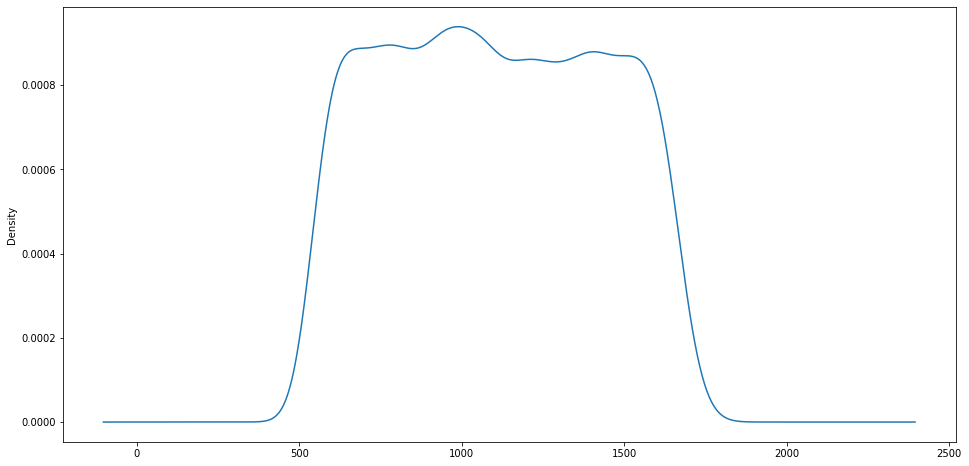

In [153]:
covid19_time_series["2020-03-27"].plot(kind="kde", figsize=(16, 8))

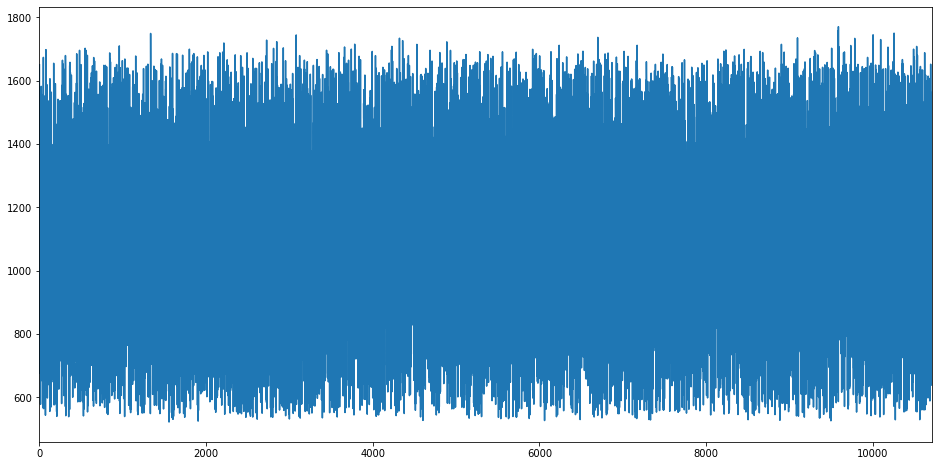

In [154]:
covid19_time_series["2020-03-27"].plot(kind="line", figsize=(16, 8));

In [0]:
covid19_time_series.to_csv("covid19_time_series.csv", index=None)